# Assignment
I'm actually going to work with a new dataset that I've been meaning to parse.  It is mostly numerical, but it does contain one important categorical variable.  The objective is to find the variables that best predict the arsenic content in water samples from the city of Durango, Mexico.  I'm going to format this one for publication.

# Predictors of arsenic content in goundwater
\[Details about where the data came from\]

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
pd.set_option('display.max_columns', None)  # Unlimited columns

## Data cleanup

In [2]:
df = pd.read_excel('RESULTADOS MUESTREO DURANGO GLOBAL FINAL 2018 REV1.xlsx',
               sheet_name='Resultados Muestreo Durango')

In [3]:
# Initial state of the dataframe
print(df.shape)
df.head()

(146, 22)


,Municipio,Localidad,Coordenadas,Unnamed: 3,Muestra,FECHA DE MUESTREO,pH,Conductividad (μs/cm),As (μg/L),Flúor (mg/L),Na+ (mg/L),K+ (mg/L),Fe+ (mg/L),Ca+ (mg/L),Mg+ (mg/L),NO3- (mg/L),Cl- (mg/L),CO3-2 (mg/L),HCO3- (mg/L),Alcalinidad total (mg CaCO3/L),SO4,Tipo de Agua
0,NaN,NaN,Longitud,Latitud,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Durango,El Nayar,-104.695,23.9629,60.0,2017-08-08,8.140,337.0,61.5,3.15,40.9220,1.4075,0.007,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,BICARBONATADA SODICA
2,Durango,Sebastián Lerdo de Tejada,-104.64,23.9572,61.0,2017-08-08,8.110,406.0,38.5,2.60,45.8850,0.6100,NaN,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,BICARBONATADA SODICA
3,Durango,Felipe Ángeles,-104.557,23.9351,62.0,2017-08-08,8.375,384.1,26.5,1.40,38.5360,6.3665,NaN,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,BICARBONATADA SODICA
4,Durango,Villa Montemorelos,-104.482,23.9918,63.0,2017-08-08,8.500,557.5,23.5,1.20,31.6805,6.7350,NaN,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,BICARBONATADA CALCICA Y/O MAGNESICA


In [10]:
# I rename all columns with simpler English names
df2 = df.rename(
    {'Municipio':'municipality',
     'Localidad':'town',
     'Coordenadas':'longitude',
     'Unnamed: 3':'latitude',
     'Muestra':'id',
     'FECHA DE MUESTREO ':'sampling_date',
     'pH':'pH',
     'Conductividad (μs/cm)':'conductivity',
     'As (μg/L)':'As',
     'Flúor (mg/L)':'F',
     'Na+ (mg/L)':'Na',
     'K+    (mg/L)':'K',
     'Fe+ (mg/L)':'Fe',
     'Ca+ (mg/L)':'Ca',
     'Mg+ (mg/L)':'Mg',
     'NO3- (mg/L)':'nitrate',
     'Cl- (mg/L)':'Cl',
     ' CO3-2 (mg/L)':'carbonate',
     'HCO3- (mg/L)':'bicarbonate',
     'Alcalinidad total                (mg CaCO3/L)':'total_alcalinity',
     'SO4':'sulfate',
     'Tipo de Agua':'water_type'}, axis='columns')

# The first row is garbage
df2 = df2.drop(index=0)

# The id column shouldn't have any predictive power
df2 = df2.drop(columns='id')

# The column for iron (Fe) is the only one with null values, and has 128/146. 
# Probably not worth fixing, so I'll drop it.
df2 = df2.drop(columns='Fe')

# I assume that the sampling date is not important.
df2 = df2.drop(columns='sampling_date')

# I counted the null values in latitude/longitude.
# Only three rows are missing their values, so I'll manually assign
# them coordinates for the corresponding towns (from Google Maps).
df2.at[62,'longitude'] = -104.703473
df2.at[62,'latitude'] = 24.024753

df2.at[53,'longitude'] = -105.555699
df2.at[53,'latitude'] = 25.461704

df2.at[73,'longitude'] = -104.643166
df2.at[73,'latitude'] = 24.041459

# Those two columns also need to be converted into number type
df2.latitude = df2.latitude.astype('float64')
df2.longitude = df2.longitude.astype('float64')

# I'll also reorder the columns a bit
df2 = df2[['As', # Dependent variable first
 'pH',
 'conductivity',
 'F',
 'Na',
 'K',
 'Ca',
 'Mg',
 'nitrate',
 'Cl',
 'carbonate',
 'bicarbonate',
 'total_alcalinity',
 'sulfate',
 'latitude',
 'longitude',
 'water_type', # Categorical features last
 'municipality',
 'town',
]]

In [11]:
# Confirming correct data types
df2.dtypes

As                  float64
pH                  float64
conductivity        float64
F                   float64
Na                  float64
K                   float64
Ca                  float64
Mg                  float64
nitrate             float64
Cl                  float64
carbonate           float64
bicarbonate         float64
total_alcalinity    float64
sulfate             float64
latitude            float64
longitude           float64
water_type           object
municipality         object
town                 object
dtype: object

In [12]:
# Confirming absence of nulls
df2.isnull().sum()

As                  0
pH                  0
conductivity        0
F                   0
Na                  0
K                   0
Ca                  0
Mg                  0
nitrate             0
Cl                  0
carbonate           0
bicarbonate         0
total_alcalinity    0
sulfate             0
latitude            0
longitude           0
water_type          0
municipality        0
town                0
dtype: int64

In [32]:
# Brief look at the clean dataframe
print(df2.shape)
df2.head()

(145, 19)


,As,pH,conductivity,F,Na,K,Ca,Mg,nitrate,Cl,carbonate,bicarbonate,total_alcalinity,sulfate,latitude,longitude,water_type,municipality,town
1,61.5,8.140,337.0,3.15,40.9220,1.4075,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,23.96292,-104.69545,BICARBONATADA SODICA,Durango,El Nayar
2,38.5,8.110,406.0,2.60,45.8850,0.6100,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,23.95718,-104.64026,BICARBONATADA SODICA,Durango,Sebastián Lerdo de Tejada
3,26.5,8.375,384.1,1.40,38.5360,6.3665,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,23.93505,-104.55661,BICARBONATADA SODICA,Durango,Felipe Ángeles
4,23.5,8.500,557.5,1.20,31.6805,6.7350,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,23.99177,-104.48167,BICARBONATADA CALCICA Y/O MAGNESICA,Durango,Villa Montemorelos
5,97.5,8.330,326.1,5.95,45.6745,1.6525,8.5190,0.2100,0.52,5.390,0.0,83.0,83.0,59.880,24.02664,-104.50855,BICARBONATADA SODICA,Durango,Belisario Domínguez


## Training/validation/test sets
It's important to use different datasets for all three functions, so I'll create those datasets now.

In [30]:
# Since sklearn dosn't have a tool for creating a validation dataset,
# I'll write one myself

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
    
    # Ensure set sizes add up to 1
    assert (train_size + val_size + test_size == 1), "The sizes of the datasets must add up to 1!"
    
    # Divide data into 'test' and leftovers
    X_leftovers, X_test, y_leftovers, y_test = train_test_split(
    X, y, test_size=test_size, 
    random_state=random_state, shuffle=shuffle)
    
    # Divide leftovers into 'train' and 'validate'
    X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, train_size=(train_size / (train_size + val_size)),
    random_state=random_state, shuffle=shuffle)
    
    # Print out the shapes of the datasets, to confirm that they're
    # what we expect
    
    print(f'X_train   : {X_train.shape}')
    print(f'X_validate: {X_validate.shape}')
    print(f'X_test    : {X_test.shape}')
    print()
    print(f'y_train   : {y_train.shape}')
    print(f'y_validate: {y_validate.shape}')
    print(f'y_test    : {y_test.shape}')
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [31]:
X = df2.drop(columns='As')
y = df2['As']
X_train, X_validate, X_test, y_train, y_validate, y_test = train_validation_test_split(X, y, random_state=42)

X_train   : (128, 18)
X_validate: (17, 18)
X_test    : (15, 18)

y_train   : (128,)
y_validate: (17,)
y_test    : (15,)


I'll store `X_test` and `y_test` for later, and carry out all further training and validation with the other datasets only.

## Data Exploration
Let's take a quick look at what Arsenic levels are present in our training data.

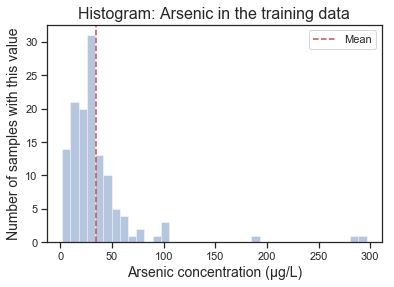

In [71]:
fig, ax = plt.subplots()
ax = sns.distplot(y_train, norm_hist=False, kde=False);
ax.set_xlabel('Arsenic concentration (µg/L)', fontsize=14)
ax.set_ylabel('Number of samples with this value', fontsize=14)
plt.axvline(x=35, color='r', linestyle='--', label='Mean');
plt.legend();
plt.title('Histogram: Arsenic in the training data', fontsize=16);

In [74]:
# And the mean value is..
np.mean(y_train)

35.54412444835938

## Model fitting

In [107]:
def score_predictions(y_validate, y_pred):
    MAE = mean_absolute_error(y_validate, y_pred)
    r2 = r2_score(y_validate, y_pred)

    print(f'Mean Absolute Error: {MAE}')
    print(f'R^2 score          : {r2}')

### Baseline
I'll start with the simplest possible model: assuming that all wells have an arsenic concentration equal to the mean of the training set.  This will provide a baseline score that I can use to judge more complex models.

In [108]:
y_pred = [np.mean(y_train)] * len(y_validate)
score_predictions(y_validate, y_pred)

Mean Absolute Error: 16.924207666677393
R^2 score          : -0.03390469712098998


## Linear Regression fit to water quality
First, I'll use only the numerical features related to water quality (measurements of pH, conductivity, and ions).

In [109]:
X_train_ions = X_train.drop(columns=['latitude','longitude','water_type','municipality','town'])
X_validate_ions = X_validate.drop(columns=['latitude','longitude','water_type','municipality','town'])

model = LinearRegression()
model.fit(X_train_ions, y_train)
y_pred = model.predict(X_validate_ions)
score_predictions(y_validate, y_pred)

Mean Absolute Error: 18.54967873285495
R^2 score          : 0.06798212500385581


Well that's embarrassing.  The MAE actually went *up*, and the R^2 score is still really low.

In [125]:
# Note that the R^2 score is actually much highe than 0.067 for the
# training set.  Which shows the importance of good validation.
model.score(X_train_ions, y_train)

0.403680544767595

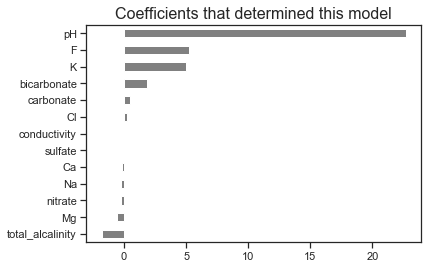

In [118]:
# What coefficients are the most important?
plt.figure()
plt.title('Coefficients that determined this model', fontsize=16)

coefficients = model.coef_
feature_names = X_validate_ions.columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

### Ridge regression to water quality
I suspect that a problem here is that we have too many variables and not enough data points. Ridge Regression should be better able than linear regression to deal with potentially under-determined models.  I'll try this one before making the problem worse by adding more variables.

In [127]:
X_train_ions = X_train.drop(columns=['latitude','longitude','water_type','municipality','town'])
X_validate_ions = X_validate.drop(columns=['latitude','longitude','water_type','municipality','town'])

model = Ridge()
model.fit(X_train_ions, y_train)
y_pred = model.predict(X_validate_ions)
score_predictions(y_validate, y_pred)

Mean Absolute Error: 18.635063711500692
R^2 score          : 0.050546715675336196


Even worse?!  

In [128]:
# Similar performance to Linear Regression on the training data
model.score(X_train_ions, y_train)

0.4034333736061585

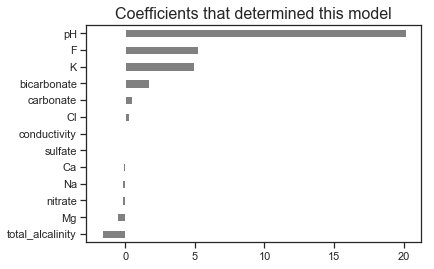

In [129]:
# And the coefficients have basically the same values.
plt.figure()
plt.title('Coefficients that determined this model', fontsize=16)

coefficients = model.coef_
feature_names = X_validate_ions.columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');